In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
torch.cuda.set_device(0)
torch.manual_seed(4)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict

class PlotHelper():
    def __init__(self):
        self.reset()

    def reset(self):
        self._f = None
        self._ax = None
        self.kvals = defaultdict(list)

    def add(self, **kval):
        for k, v in kval.items():
            self.kvals[k].append(v)

    @property
    def fig(self):
        if self._f is None:
            self.new()
        return self._f

    @property
    def ax(self):
        if self._ax is None:
            self.new()
        return self._ax

    def new(self):
        self._f, self._ax = plt.subplots(1,1)
        plt.ion()
        self.fig.show()

    def show(self):
        names = []
        self.ax.clear()
        for k, v in self.kvals.items():
            names.append(k)
            self.ax.plot(v)
        self.ax.legend(names)
        self.fig.canvas.draw()

In [3]:
class SudokuSolver(nn.Module):
    def __init__(self, board_size):
        super().__init__()
        self.W = torch.nn.Parameter(torch.rand((1,9,9,9)))
        
    def __call__(self, X):
        return self.W

In [4]:
def process_inputs(X):
    is_input = X.sum(dim=3, keepdim=True)
    
    X = X.view(X.size(0), -1)
#     Y = Y.view(Y.size(0), -1)
    is_input = is_input.view(is_input.size(0), -1)
    
    return is_input

In [5]:
def show_sudoku(X):
    return (torch.argmax(X, 2) + 1) * (X.sum(2).long())

In [6]:
def isvalid_sudoku(X):
    return all([len(X[:, i].unique()) == 9 for i in range(9)])

In [7]:
def partial_sudoku(X):
    return any([len(X[:, i].unique()) == 9 for i in range(9)])

In [8]:
# def get_all_constraint():
#     for i in range(10):
#         yield lambda X, i=i: len(X[:, i].unique()) == 9

def isvalid_sudoku_row_01(X):
    return len(X[:, 0].unique()) == 9 and len(X[:, 1].unique()) == 9

def isvalid_sudoku_row(X):
    return len(X.unique()) == 9

def isvalid_sudoku_col(X):
    return len(X[:, :, 0].unique()) == 9
def isvalid_sudoku_col_1(X):
    return len(X[:, :, 1].unique()) == 9
def isvalid_sudoku_col_2(X):
    return len(X[:, :, 2].unique()) == 9
def isvalid_sudoku_col_3(X):
    return len(X[:, :, 3].unique()) == 9
def isvalid_sudoku_col_4(X):
    return len(X[:, :, 4].unique()) == 9
def isvalid_sudoku_col_5(X):
    return len(X[:, :, 5].unique()) == 9
def isvalid_sudoku_col_6(X):
    return len(X[:, :, 6].unique()) == 9
def isvalid_sudoku_col_7(X):
    return len(X[:, :, 7].unique()) == 9
def isvalid_sudoku_col_8(X):
    return len(X[:, :, 8].unique()) == 9

def isvalid_sudoku_sqr_0(X):
    return len(X[:, 0:3, 0:3].unique()) == 9
def isvalid_sudoku_sqr_1(X):
    return len(X[:, 0:3, 3:6].unique()) == 9
def isvalid_sudoku_sqr_2(X):
    return len(X[:, 0:3, 6:9].unique()) == 9
def isvalid_sudoku_sqr_3(X):
    return len(X[:, 3:6, 0:3].unique()) == 9
def isvalid_sudoku_sqr_4(X):
    return len(X[:, 3:6, 3:6].unique()) == 9
def isvalid_sudoku_sqr_5(X):
    return len(X[:, 3:6, 6:9].unique()) == 9
def isvalid_sudoku_sqr_6(X):
    return len(X[:, 6:9, 0:3].unique()) == 9
def isvalid_sudoku_sqr_7(X):
    return len(X[:, 6:9, 3:6].unique()) == 9
def isvalid_sudoku_sqr_8(X):
    return len(X[:, 6:9, 6:9].unique()) == 9

def isvalid_sudoku_row_col(row, col):
    val = len(row.unique()) == 9 and len(col.unique()) == 9 and (row[0][6] == col[0][2])
    return val

def isvalid_sudoku_row_sqr(row, sqr):
    val = len(row.unique()) == 9 and len(sqr.unique()) == 9 and (row[0][6:] == sqr[0][6:]).all()
    return val

def isvalid_sudoku_col_sqr(col, sqr):
    val = len(col.unique()) == 9 and len(sqr.unique()) == 9  and (col[0][:3] == sqr[0][[0, 3, 6]]).all()
    return val

In [9]:
X= torch.tensor([[6, 4, 0, 1, 0, 0, 8, 5, 9],
                 [8, 9, 5, 6, 0, 4, 2, 7, 0],
                 [0, 0, 0, 9, 0, 5, 0, 3, 4],
                 [0, 3, 6, 0, 4, 8, 9, 2, 0],
                 [9, 0, 2, 3, 0, 7, 0, 6, 5],
                 [0, 7, 4, 0, 9, 6, 0, 8, 0],
                 [4, 6, 0, 0, 2, 3, 5, 1, 8], #5, 0, 8
                 [0, 0, 7, 0, 0, 9, 0, 4, 0],
                 [3, 0, 8, 4, 0, 1, 0, 0, 0],
                 ])

Y= torch.tensor([[6, 4, 3, 1, 7, 2, 8, 5, 9],
                 [8, 9, 5, 6, 3, 4, 2, 7, 1],
                 [7, 2, 1, 9, 8, 5, 6, 3, 4],
                 [1, 3, 6, 5, 4, 8, 9, 2, 7],
                 [9, 8, 2, 3, 1, 7, 4, 6, 5],
                 [5, 7, 4, 2, 9, 6, 1, 8, 3],
                 [4, 6, 9, 7, 2, 3, 5, 1, 8],
                 [2, 1, 7, 8, 5, 9, 3, 4, 6],
                 [3, 5, 8, 4, 6, 1, 7, 9, 2],
                 ])

In [10]:
X_ = torch.zeros((9,9,9))
for i in range(9):
    for j in range(9):
        if X[i][j].item() > 0:
            X_[i][j][X[i][j].item() - 1] = 1        
            
Y_ = torch.zeros((9,9,9))
for i in range(9):
    for j in range(9):
        if Y[i][j].item() > 0:
            Y_[i][j][Y[i][j].item() - 1] = 1
            
X = X_.unsqueeze(0)
Y = Y_

is_input = process_inputs(X)

In [11]:
# Input
print(show_sudoku(X[0])) # Shape of X_in: (BxHxWxC)

tensor([[6, 4, 0, 1, 0, 0, 8, 5, 9],
        [8, 9, 5, 6, 0, 4, 2, 7, 0],
        [0, 0, 0, 9, 0, 5, 0, 3, 4],
        [0, 3, 6, 0, 4, 8, 9, 2, 0],
        [9, 0, 2, 3, 0, 7, 0, 6, 5],
        [0, 7, 4, 0, 9, 6, 0, 8, 0],
        [4, 6, 0, 0, 2, 3, 5, 1, 8],
        [0, 0, 7, 0, 0, 9, 0, 4, 0],
        [3, 0, 8, 4, 0, 1, 0, 0, 0]])


In [12]:
# Groundtruth
print(show_sudoku(Y))

tensor([[6, 4, 3, 1, 7, 2, 8, 5, 9],
        [8, 9, 5, 6, 3, 4, 2, 7, 1],
        [7, 2, 1, 9, 8, 5, 6, 3, 4],
        [1, 3, 6, 5, 4, 8, 9, 2, 7],
        [9, 8, 2, 3, 1, 7, 4, 6, 5],
        [5, 7, 4, 2, 9, 6, 1, 8, 3],
        [4, 6, 9, 7, 2, 3, 5, 1, 8],
        [2, 1, 7, 8, 5, 9, 3, 4, 6],
        [3, 5, 8, 4, 6, 1, 7, 9, 2]])


In [13]:
import sys
sys.path.append("..")


import torch.optim as optim
from pytorch_constraints.constraint import constraint
from pytorch_constraints.sampling_solver import WeightedSamplingSolver

model = SudokuSolver(9)
# model.convolutions[-1].register_backward_hook(backward_hook)
sudoku_constraint = constraint(isvalid_sudoku, WeightedSamplingSolver(num_samples=1000))
sudoku_partial_constraint = constraint(partial_sudoku, WeightedSamplingSolver(num_samples=1000))
optimizer = optim.SGD(model.parameters(), lr=1.0)
# optimizer = optim.Adam(model.parameters(), lr=0.01)

row01_constraint = constraint(isvalid_sudoku_row_01, WeightedSamplingSolver(num_samples=200))

row_constraint = constraint(isvalid_sudoku_row, WeightedSamplingSolver(num_samples=2000))
row_col_constraint = constraint(isvalid_sudoku_row_col, WeightedSamplingSolver(num_samples=10000))
row_sqr_constraint = constraint(isvalid_sudoku_row_sqr, WeightedSamplingSolver(num_samples=10000))
col_sqr_constraint = constraint(isvalid_sudoku_col_sqr, WeightedSamplingSolver(num_samples=10000))

In [14]:
from tqdm import tqdm

input = show_sudoku(X[0])
X = X
is_input = is_input[0]    

In [15]:
# with torch.no_grad():
#     model.W[0][2,6][5] = 0.1338
#     model.W[0][2,6][0] = 0.0638

In [16]:
plot_loss = PlotHelper()
for epoch in tqdm(range(90)):
    row_losses = []
    col_losses = []
    sqr_losses = []

    optimizer.zero_grad()
    
    output = model(X[:1])
    loss = F.cross_entropy(output.view(-1,9), Y.argmax(dim=2).view(-1), reduction='none') * is_input
    
    for i in range(0, 9):
        row_losses += [row_constraint(output[:, i], input=(input[i,:],))]
        col_losses += [row_constraint(output[:, :, i], input=(input[:,i],))]

    for i in range(0, 9, 3):
        for j in range(0, 9, 3):
            sqr_losses += [row_constraint(output[:, i:i+3, j:j+3].reshape(1,9,9), input=(input[i:i+3, j:j+3].reshape(9),))]
    
    row_losses = torch.stack(row_losses)
    col_losses = torch.stack(col_losses)
    sqr_losses = torch.stack(sqr_losses)
    
    row_multipliers = row_losses / (row_losses.sum() + col_losses.sum() + sqr_losses.sum())
    col_multipliers = col_losses / (row_losses.sum() + col_losses.sum() + sqr_losses.sum())
    sqr_multipliers = sqr_losses / (row_losses.sum() + col_losses.sum() + sqr_losses.sum())
    
    row_loss = (row_losses * row_multipliers).sum()
    col_loss = (col_losses * col_multipliers).sum()
    sqr_loss = (sqr_losses * sqr_multipliers).sum()
    
    total_loss = loss.sum() + row_loss + col_loss + sqr_loss
    recon_loss = (output[0].argmax(dim =-1) != Y.argmax(dim=-1)).sum()
    
    plot_loss.add(loss=loss.mean().data, row_loss=row_loss.data, col_loss=col_loss.data, sqr_loss=sqr_loss.data, recon_loss = recon_loss)

    total_loss.backward()

    optimizer.step()

100%|██████████| 90/90 [05:52<00:00,  3.91s/it]


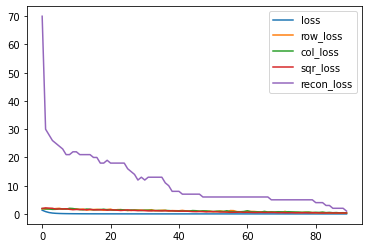

In [17]:
plot_loss.show()

tensor([[6, 4, 3, 1, 7, 2, 8, 5, 9],
        [8, 9, 5, 6, 3, 4, 2, 7, 1],
        [7, 2, 1, 9, 8, 5, 6, 3, 4],
        [1, 3, 6, 5, 4, 8, 9, 2, 7],
        [9, 8, 2, 3, 1, 7, 4, 6, 5],
        [5, 7, 4, 2, 9, 6, 1, 8, 3],
        [4, 6, 9, 7, 2, 3, 5, 1, 8],
        [2, 1, 7, 8, 5, 9, 3, 4, 6],
        [3, 5, 8, 4, 6, 1, 7, 9, 2]])


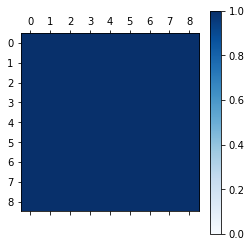

In [21]:
output = model(X[:1])
print((output[0].argmax(dim =-1) + 1).data)
heatmap = plt.matshow((output[0].argmax(dim =-1) == Y.argmax(dim=-1)), cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.colorbar(heatmap)

In [20]:
print(show_sudoku(Y))

tensor([[6, 4, 3, 1, 7, 2, 8, 5, 9],
        [8, 9, 5, 6, 3, 4, 2, 7, 1],
        [7, 2, 1, 9, 8, 5, 6, 3, 4],
        [1, 3, 6, 5, 4, 8, 9, 2, 7],
        [9, 8, 2, 3, 1, 7, 4, 6, 5],
        [5, 7, 4, 2, 9, 6, 1, 8, 3],
        [4, 6, 9, 7, 2, 3, 5, 1, 8],
        [2, 1, 7, 8, 5, 9, 3, 4, 6],
        [3, 5, 8, 4, 6, 1, 7, 9, 2]])
